# Introducing the fumbbl_replays Python package

The `fumbbl_replays` Python package is about analyzing game logs for the board game Blood Bowl.
On the FUMBBL website, a lot of high quality replay data is available as well as an API to conveniently fetch the data.
In addition, the API provides up to date roster information.
To use do useful analyses (aka nufflytics) in Python with this data, we need a utility package / library.
In R, a similar package exists to work with BB2 replays [https://github.com/nufflytics/nufflytics].
To my knowledge, no work has been done yet on BB3 replay files.

We also need a standard way to describe Blood Bowl games in a compact way, that is both human and machine readable.
In chess, there is the **Portable Game Notation (PGN)**. PGN has become the de facto standard of describing Chess games.
For Blood Bowl, already in 2002 some work has been done towards this end. David Morgan-Mar developed a notation for the purpose of sharing game logs over the internet. [https://www.dangermouse.net/games/bloodbowl/rules.html]

If we could converge on a standard Fantasy Football Game Notation, it would serve many purposes:
* It would allow us to interchange data between software
* it would help to train AI engines.

So the package is being developed with this end goal in mind. As Blood Bowl is a much complexer game than Chess, we need some intermediate goals that bring us closer to the end goal. Thus, I started with extracting board positions, short hand notation for board pieces (players) and codifying player moves.

In [2]:
%pip install -e . --quiet

You should consider upgrading via the '/home/gertjan/venvs/requests_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Plotting Blood Bowl board positions

If we want to describe a board state, we need to describe the pieces, and we need to describe the location of the pieces.
(We also need to describe the "state" of the pieces, as players can be either standing, prone, or stunned, and can be in various special states such as "Bone head", "Rooted", "Hypnotized" etc. A full game state also contains additional information on rerolls, players on the bench etc. This is not yet implemented)

Let's start with the location of the pieces. A grid reference system is needed.
The game board of Blood Bowl has dimensions 15 x 26.
It has cognitive benefit to use numbers for one dimension, and letters for the other dimensions. Fancy word: alphanumeric.
Chess over the centuries has had various notations, and this notation is the one that became universally accepted.
[https://en.wikipedia.org/wiki/Algebraic_notation_(chess)]
The only choice left for us is then, which axis should have letters, and which axis should have the numbers.

A strong argument was made on the BotBowl discord that distance to the end zone is very important in BB.
By using numbers for the long axis, we can easily deduce that a Gutter Runner at position c15 is in scoring position: It needs 11 movement to score a touchdown at c26.
This notation is also used by Cow Daddy Gaming in his "What´s the play" puzzles.

I wrote a function `show_boardpos()` that displays the name of all the board positions.


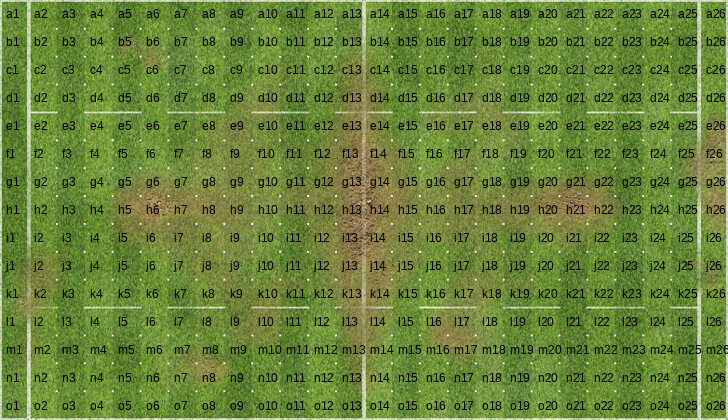

In [3]:
import fumbbl_replays as fb

fb.show_boardpos(rotation = 'H')

Next is that we need a way to describe the playing pieces, and visualize them. In chess it is easy, there are only six different ones.
In Blood Bowl, there are roughly 200 different playing pieces (30 teams, times 5 positionals, plus 50+ star players).
Here the concept of a roster can help us out. 
I wrote a function `fetch_roster()` that fetches rosters from FUMBBL and displays the positions.
It also contains links to icons that can represent the piece on the board.
Take for example the High Elf roster.

In [4]:
roster = fb.fetch_roster("High Elf")
roster

positionId positionName shorthand                        icon_path      race
0      39330      Lineman         L  https://fumbbl.com/i/585638.png  High Elf
1      39331      Thrower         T  https://fumbbl.com/i/436284.png  High Elf
2      39332      Catcher         C  https://fumbbl.com/i/585639.png  High Elf
3      39333      Blitzer         Z  https://fumbbl.com/i/436286.png  High Elf

It has four different pieces or "positionals". It turns out that FUMBBL has already solved our problem of denoting them, introducing a shorthand text reference. 
So if we want to describe some action involving a High Elf Catcher, and there are four of them on the board, we could denote them by C1, C2, C3 and C4.
This is compact, and has meaning within the context of the High Elf roster.

If we combine the descriptions of the pieces, and their location, we have enough to describe for example an initial setup formation before kick-off.

In [5]:
roster = fb.fetch_roster("High Elf")

my_setup = ['setup', ['L1: g13', 'L2: h13', 'L3: i13', 'Z1: c11', 'Z2: m11', 'T1: h6', 'L4: e11', 
                      'L5: k11', 'C1: l10', 'C2: d10', 'L6: h11']]

I wrote a function `create_position()` that combines the roster and the setup annotation to create an object that contains all the information to make a nice plot of the board state. The function `print_position()` prints a nicely formatted summary of the position.
As default, a position is created for the home team, denoted as "teamHome".

In [6]:
positions = fb.create_position(roster, my_setup)
fb.print_position(positions)

home_away      race short_name positionName boardpos
5   teamHome  High Elf         T1      Thrower       h6
9   teamHome  High Elf         C2      Catcher      d10
8   teamHome  High Elf         C1      Catcher      l10
3   teamHome  High Elf         Z1      Blitzer      c11
6   teamHome  High Elf         L4      Lineman      e11
10  teamHome  High Elf         L6      Lineman      h11
7   teamHome  High Elf         L5      Lineman      k11
4   teamHome  High Elf         Z2      Blitzer      m11
0   teamHome  High Elf         L1      Lineman      g13
1   teamHome  High Elf         L2      Lineman      h13
2   teamHome  High Elf         L3      Lineman      i13

Let's suppose that the High Elf team is playing against a Gnome team. Let's also fetch a Gnome roster and create a board position on the other half of the pitch.
As we already have a home team, we refer to this team as "teamAway".

In [7]:
roster = fb.fetch_roster("Gnome")

my_setup = ['setup', ['T2: j14', 'T1: f14', 'F1: h20', 'I1: b14', 'I2: n14', 'L3: e14', 'L6: k14', 
                      'B2: m15', 'B1: c15', 'L4: g15', 'F2: i16']]

positions2 = fb.create_position(roster, my_setup, 'teamAway')

fb.print_position(positions2)

home_away   race short_name           positionName boardpos
3   teamAway  Gnome         I1      Gnome Illusionist      b14
5   teamAway  Gnome         L3          Gnome Lineman      e14
1   teamAway  Gnome         T1  Altern Forest Treeman      f14
0   teamAway  Gnome         T2  Altern Forest Treeman      j14
6   teamAway  Gnome         L6          Gnome Lineman      k14
4   teamAway  Gnome         I2      Gnome Illusionist      n14
8   teamAway  Gnome         B1      Gnome Beastmaster      c15
9   teamAway  Gnome         L4          Gnome Lineman      g15
7   teamAway  Gnome         B2      Gnome Beastmaster      m15
10  teamAway  Gnome         F2           Woodland Fox      i16
2   teamAway  Gnome         F1           Woodland Fox      h20

As a final step before plotting, we add both positions together.
As both are `pandas` DataFrames, we use the `concat()` function from `pandas`  to combine ("concatenate") them.

In [8]:
import pandas as pd

positions = pd.concat([positions, positions2])

The function `create_plot()` plots the board position.
By default, it plots a horizontal pitch, with the team denoted as "teamHome" in red, and the other team in blue.

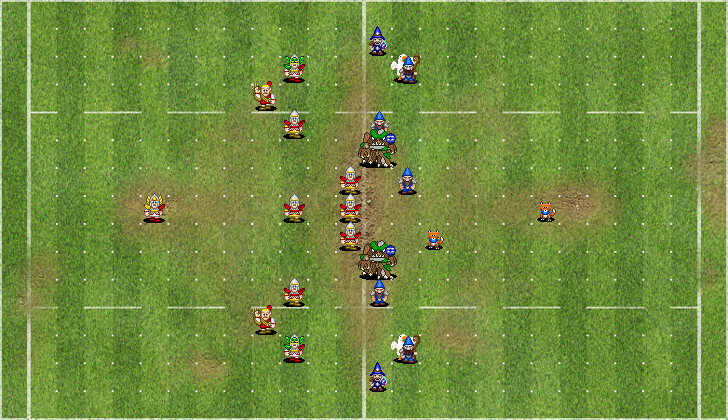

In [9]:
fb.create_plot(positions)

The `create_plot()` function allows us the swap the color of the teams, to change the pitch orientation to vertical, and to add a layer of semi-transparant tacklezones.

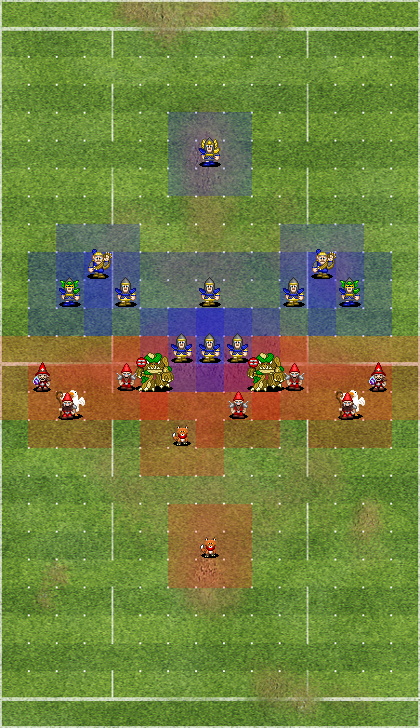

In [10]:
fb.create_plot(positions, red_team = "teamAway", orientation = 'V', tackle_zones = True)

The library also support moving single pieces (players). It currently only works for pieces that already exist in a board position.
In the plot above, suppose we want to move the Woodland Fox F1 to board position `o26`:

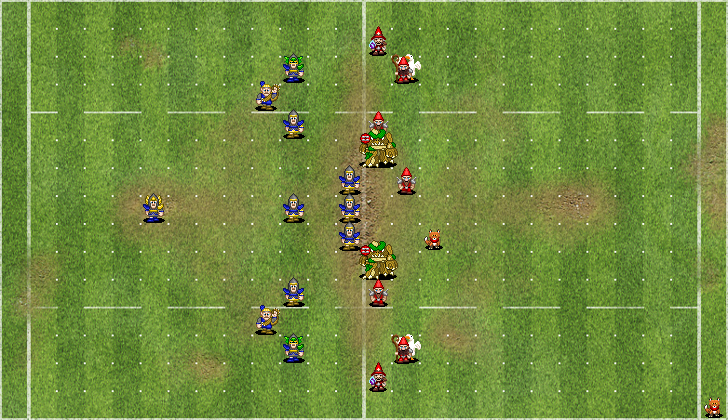

In [11]:
positions = fb.move_piece(positions, "teamAway", "F1", "o26")

fb.create_plot(positions, red_team = "teamAway")

# Plotting board positions from FUMBBL replays

Up until now, we created board positions from scratch, using rosters from FUMBBL and a simple way to describe a board position.
The package also allows us to plot board positions extracted from FUMBBL replay files.
At this moment, only the board position right before kick-off can be plotted.
Suppose we want to plot this position for [match 4551601](https://www.fumbbl.com/p/match?id=4551601).

We first need to fetch the replay data. The `fetch_data()` function takes the match_id as argument and returns five objects:
the match_id, replay_id, a positions object, which team is the receiving team (i.e. playing offense), and some metadata (coach names, race names, and match touchdown result).

In [30]:
match_id, replay_id, positions, receiving_team, metadata = fb.fetch_data(match_id = 4543460)

To plot the board state right before kick-off, we can use the `create_plot()` function in the same way as above.
We plot the receiving team in red so we can see which team is playing offense and which team is playing defense.

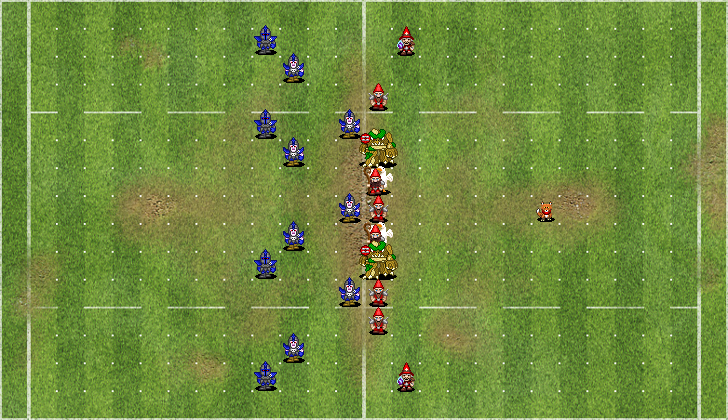

In [31]:
fb.create_plot(positions, red_team = receiving_team)

Adjusting this board position by moving players one-by-one works also in the same way as above.

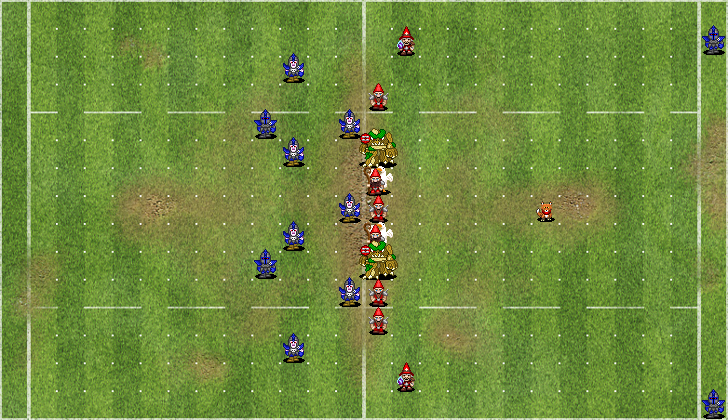

In [32]:
positions = fb.move_piece(positions, "teamHome", "Z1", "b26")
positions = fb.move_piece(positions, "teamHome", "Z2", "o26")

fb.create_plot(positions, red_team = receiving_team)

Suppose we think that the offensive setup is awesome, and we wish to share this setup with other coaches.
Here the compact way to describe a setup using player abbreviations and the alphanumeric grid system comes in handy.
To get the position in this notation I wrote the function `get_position()`.


In [33]:
fb.get_position(positions, home_away = 'teamAway')


['setup', ['T1: j14', 'T2: f14', 'B1: g14', 'B2: i14', 'L1: h14', 'I1: b15', 'I2: n15', 'L4: l14', 'L3: d14', 'L2: k14', 'F2: h20']]


Suppose we think this setup is awesome, but it would be even better if the illusionist in row `b` would be a second Woodland Fox.
We can take the setup (copy-paste), change the setup slightly, and create a new position.
As we now only have a single team, we can rotate the pitch and crop to show only the upper part of it.

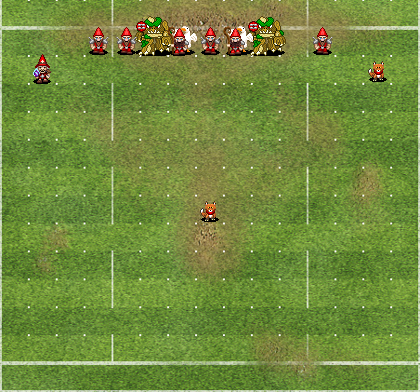

In [36]:
roster = fb.fetch_roster("Gnome")

my_setup = ['setup', ['T1: j14', 'T2: f14', 'B1: g14', 'B2: i14', \
                      'L1: h14', 'F1: b15', 'I2: n15', 'L4: l14', \
                        'L3: d14', 'L2: k14', 'F2: h20']]

positions = fb.create_position(roster, my_setup)

fb.create_plot(positions, orientation= "V", crop = "lower")

# Working with raw replays directly

It is also possible to work with the raw FUMBBL replay files directly.
I made a start with describing the file format in `doc/fumbbl_replay_file_format.md`.
We can use `fetch_replay()` to retrieve a replay in JSON format.
JSON consists of key-value pairs.
We can for example query the value of the key "gameStatus":

In [17]:
my_replay = fb.fetch_replay(match_id = 4447439)
my_replay['gameStatus']

'uploaded'

The replay contains both a game log, as well as full roster information on both teams.
We can extract the roster information from the replay using the function `extract_rosters_from_replay()`.


In [18]:
pd.set_option('display.max_colwidth', None)

df_positions = fb.extract_rosters_from_replay(my_replay)
(df_positions
 .query("home_away == 'teamAway'")
 .filter(['short_name', 'positionName', 'skillArray'])
)

short_name          positionName  \
0         Tr1  Loren Forest Treeman   
1          W1             Wardancer   
2          W2             Wardancer   
3          T1               Thrower   
4          C1               Catcher   
5          C2               Catcher   
6          L1      Wood Elf Lineman   
7          L2      Wood Elf Lineman   
8          L3      Wood Elf Lineman   
9          L4      Wood Elf Lineman   
10         L5      Wood Elf Lineman   

                                                                               skillArray  
0   [Loner, Mighty Blow, Stand Firm, Strong Arm, Take Root, Thick Skull, Throw Team-Mate]  
1                                                                    [Block, Dodge, Leap]  
2                                                        [Strip Ball, Block, Dodge, Leap]  
3                                                                          [Leader, Pass]  
4                                                                          [Catch, Dodge]  
5                                                                          [Catch, Dodge]  
6                                                                                 [Dodge]  
7                                                                                 [Dodge]  
8                                                                                      []  
9                                                                               [Wrestle]  
10                                                                              [Wrestle]

I wrote a replay parser that parses the gameLog section of a replay and transforms this into a `pandas` DataFrame object, i.e. a flat 2D table with rows and columns.

In [19]:
df = fb.parse_replay(my_replay)
(df[0:4]
 .filter(['commandNr', 'turnNr', 'turnMode', 'Half', 'modelChangeId', 'modelChangeValue'])
)

commandNr  turnNr   turnMode  Half              modelChangeId  \
0          1       0  startGame     0  fieldModelAddPlayerMarker   
1          1       0  startGame     0  fieldModelAddPlayerMarker   
2          1       0  startGame     0  fieldModelAddPlayerMarker   
3          1       0  startGame     0  fieldModelAddPlayerMarker   

                                             modelChangeValue  
0  {'playerId': '15440786', 'homeText': 'B', 'awayText': 'B'}  
1  {'playerId': '15440787', 'homeText': 'G', 'awayText': 'G'}  
2  {'playerId': '15440788', 'homeText': 'G', 'awayText': 'G'}  
3  {'playerId': '15440790', 'homeText': 'G', 'awayText': 'G'}

We can use the `pandas` `query()` function to select rows based on conditions.
This query selects all "fieldModelSetPlayerCoordinate" commands during setup before turn 1.

In [20]:
positions = (df.query('turnNr == 0 & turnMode == "setup" & Half == 1 & \
                     modelChangeId == "fieldModelSetPlayerCoordinate"')
                     .groupby('modelChangeKey')
                     .tail(1))

(positions[0:4]
 .filter(['commandNr', 'turnNr', 'turnMode', 'Half', 'modelChangeId', 'modelChangeValue'])
)

commandNr  turnNr turnMode  Half                  modelChangeId  \
77         20       0    setup     1  fieldModelSetPlayerCoordinate   
79         21       0    setup     1  fieldModelSetPlayerCoordinate   
81         22       0    setup     1  fieldModelSetPlayerCoordinate   
84         24       0    setup     1  fieldModelSetPlayerCoordinate   

   modelChangeValue  
77          [12, 6]  
79          [12, 7]  
81          [12, 8]  
84          [10, 4]

As I was interested in **defensive** setup formations, I wrote a function `determine_receiving_team_at_start()` that does exactly what you'd expect given its name :)

In [21]:
fb.determine_receiving_team_at_start(df)

'teamAway'

# Towards FFGN

Finally, there is a function `fumbbl2ffgn()` that is very much a work in progress.
The idea is to take a game log, and systematically strip away all information that is redundant regarding the actual logging of what happened during the game. A minimal information set would consist of all actions taken, all decisions that were made (i.e. to use the dodge skill) and all dice results.
After we have such a set, we can transform this information set to a compact annotation that is readable both by humans and machines, and is still a complete description of the game, in that the full game can be reproduced.
The compact annotation would then be candidate to become the official "Fantasy Football Game Notation", or FFGN for short.

In [22]:
my_game_log = fb.fumbbl2ffgn(match_id = 4447439)

This is where it currently stands. A single gamelog is now roughly 800 lines of text.
The table below describes the first turn of a Wood Elf team against Necromantic.

In [23]:
pd.set_option('display.max_colwidth', None)

# Turn 1 for the offensive
(my_game_log
 .query("Half == 1 & turnNr == 1 & commandNr > 88 & commandNr < 211")
 .filter(['modelChangeKey', 'modelChangeValue'])
)

modelChangeKey  \
29         ['T1']   
30         ['C1']   
31         ['L1']   
32         ['L4']   
33         ['L5']   
34         ['L4']   
35              0   
36        ['Tr1']   
37        ['Tr1']   
38         ['L2']   
39        ['Tr1']   
40              0   
41         ['L5']   
42         ['L4']   
43              0   
44         ['L3']   
45         ['L2']   
46         ['C2']   
47         ['W1']   
48         ['W2']   
49         ['W2']   
50         ['W2']   
51            ___   

                                                                                                        modelChangeValue  
29                                                                                        [j17, i17, h17, g17, f17, e17]  
30                                                                                        [g17, f17, e18, d17, c17, b17]  
31                                                                                                       [d14, e13, f13]  
32                                                                    Block roll:['!', '!'] | block result: ! (POW/PUSH)  
33                                                                                                                 [g12]  
34                                                                                                                 [g13]  
35                                                                  Armour roll: [3, 5] | Armour of ['L5'] is not broken  
36                                                                             Confusion roll: 2 | ['Tr1'] acts normally  
37                                                                    Block roll:['>', '%', '*'] | block result: * (POW)  
38                                                                                                                 [i12]  
39                                                                                                                 [h13]  
40                                                                  Armour roll: [4, 2] | Armour of ['L2'] is not broken  
41                                                                    Block roll:['>', '!'] | block result: ! (POW/PUSH)  
42                                                                                                                 [h12]  
43                                                                  Armour roll: [2, 5] | Armour of ['L4'] is not broken  
44                                                                                        [m16, l16, k16, j16, i16, h16]  
45                                                                                   [l15, k15, j15, i15, h15, g15, f15]  
46                                                                                                                 [c15]  
47                                                                                                       [d16, c16, b16]  
48                                                                                        [g18, f18, e18, d18, c18, b18]  
49  {'reportId': 'pickUpRoll', 'playerId': '['W2']', 'successful': True, 'roll': 4, 'minimumRoll': 2, 'reRolled': False}  
50                                                                                                            [c18, d18]  
51                                                                                                           End of Turn

*Thrower 1 moves. Catcher 1 moves. Lineman 1 moves. Lineman 4 blocks, chooses pow/push, pows Zombie lineman L5 into square g12, follows up, does not break armor.*
*Treeman does not take root, does a 3D block on Zombie lineman 2, chooses pow into square i12, follows up to square h13, does not break armor.*
*Lineman 5 blocks zombie lineman L4, pows into h12, does not follow up, does not break armor. Then linemen L3, L2, catcher C2 and wardancer W1 all do a move action.*
*Finally Wardancer W2 moves, picks up the ball and moves a bit more. End turn.*